<a href="https://colab.research.google.com/github/datamongerbonny/geopy-notebooks/blob/main/10_FAR_TutorialData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Imports
import os
from shutil import copy2
import urllib.request
from zipfile import ZipFile

import forestatrisk as far

no display found. Using non-interactive Agg backend
# forestatrisk: modelling and forecasting deforestation in the tropics.
# https://ecology.ghislainv.fr/forestatrisk/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from patsy import dmatrices
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss


In [ ]:
# Make output directory
far.make_dir("output")

In [ ]:
help(far.make_dir)

Help on function make_dir in module forestatrisk.misc.miscellaneous:

make_dir(newdir)
    Make new directory
    
        * Already exists, silently complete
        * Regular file in the way, raise an exception
        * Parent directory(ies) does not exist, make them as well
    
    :param newdir: Directory path to create.



In [ ]:
help(far.sample)

Help on function sample in module forestatrisk.build_data.sample:

sample(nsamp=10000, adapt=True, seed=1234, csize=10, var_dir='data', input_forest_raster='forest.tif', output_file='output/sample.txt', blk_rows=0)
    Sample points and extract raster values.
    
    This function (i) randomly draws spatial points in deforested and
    forested areas and (ii) extract environmental variable values for
    each spatial point.
    
    :param nsamp: Number of random spatial points.
    
    :param adapt: Boolean. Adapt ``nsamp`` to forest area: 1000 for 1 Mha of
        forest, with min=10000 and max=50000. Default to ``True``.
    
    :param seed: Seed for random number generator.
    
    :param csize: Spatial cell size in km.
    
    :param var_dir: Directory with raster data.
    
    :param input_forest_raster: Name of the forest raster file
       (1=forest, 0=deforested) in the var_dir directory.
    
    :param output_file: Path to file to save sample points.
    
    :param bl

In [ ]:
# Source of the data
url = "https://github.com/ghislainv/forestatrisk/raw/master/docsrc/notebooks/data_GLP.zip"

if os.path.exists("data_GLP.zip") is False:
    urllib.request.urlretrieve(url, "data_GLP.zip")

with ZipFile("data_GLP.zip", "r") as z:
    z.extractall("data")

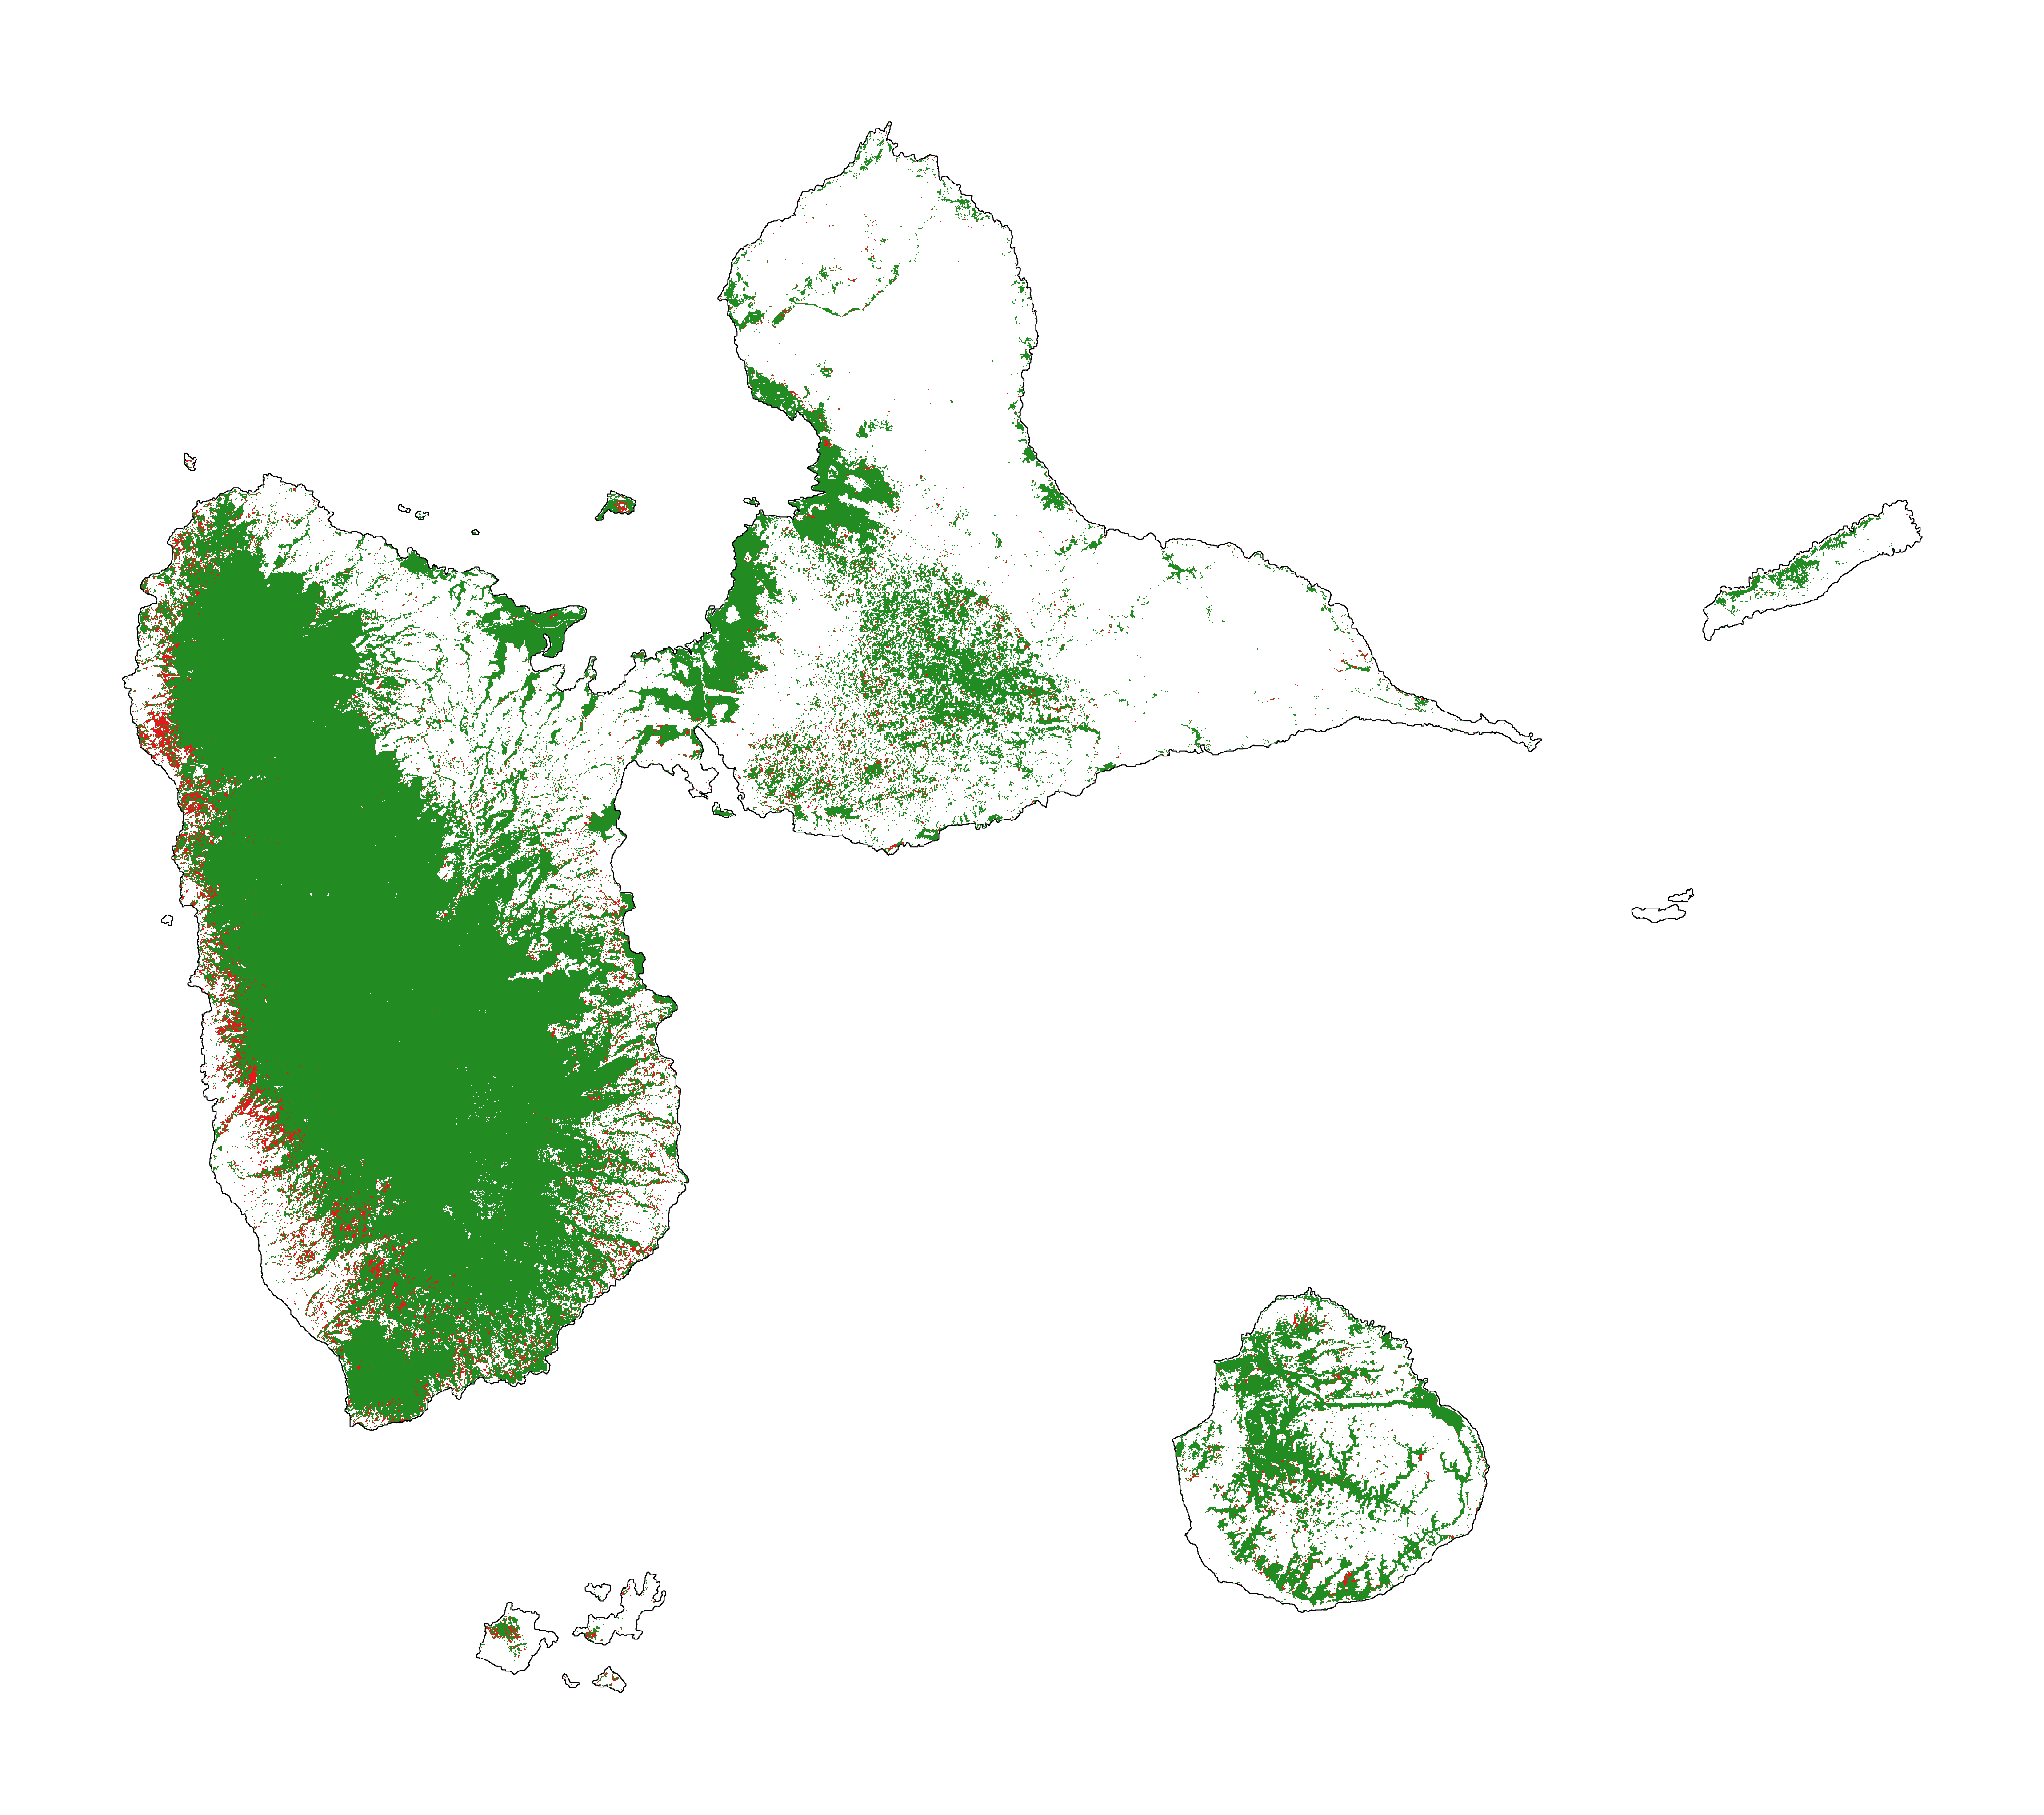

In [ ]:
# Plot forest
fig_fcc23 = far.plot.fcc(
    input_fcc_raster="data/fcc23.tif",
    maxpixels=1e8,
    output_file="output/fcc23.png",
    borders="data/ctry_PROJ.shp",
    linewidth=0.3, dpi=500)

In [ ]:
# Sample points
dataset = far.sample(nsamp=10000, adapt=True, seed=1234, csize=10,
                     var_dir="data",
                     input_forest_raster="fcc23.tif",
                     output_file="output/sample.txt",
                     blk_rows=0)

Sample 2x 10000 pixels (deforested vs. forest)
Divide region in 168 blocks
Compute number of deforested and forest pixels per block
100%
Draw blocks at random
Draw pixels at random in blocks
100%
Compute center of pixel coordinates
Compute number of 10 x 10 km spatial cells
... 99 cells (9 x 11)
Identify cell number from XY coordinates
Make virtual raster with variables as raster bands
Extract raster values for selected pixels
100%
Export results to file output/sample.txt


In [ ]:
# Remove NA from data-set (otherwise scale() and
# model_binomial_iCAR do not work)
dataset = dataset.dropna(axis=0)
# Set number of trials to one for far.model_binomial_iCAR()
dataset["trial"] = 1
# Print the first five rows
print(dataset.head(5))

   altitude  dist_defor  dist_edge  dist_river  dist_road  dist_town  fcc23  \
0      30.0       642.0       30.0      8448.0     1485.0     6364.0    0.0   
1      37.0       765.0       30.0      8583.0     1697.0     6576.0    0.0   
2      78.0       216.0       30.0      7722.0      949.0     5743.0    0.0   
3      80.0       277.0       30.0      8168.0     1172.0     6047.0    0.0   
4      46.0        30.0       30.0      6179.0      541.0     6690.0    0.0   

    pa  slope          X          Y  cell  trial  
0  0.0    8.0 -6842295.0  1851975.0   4.0      1  
1  0.0    7.0 -6842235.0  1852095.0   4.0      1  
2  0.0    5.0 -6842535.0  1851195.0   4.0      1  
3  0.0    2.0 -6842445.0  1851615.0   4.0      1  
4  0.0    1.0 -6840465.0  1849755.0   4.0      1  


In [ ]:
# Neighborhood for spatial-autocorrelation
nneigh, adj = far.cellneigh(raster="data/fcc23.tif", csize=10, rank=1)

# List of variables
variables = ["scale(altitude)", "scale(slope)",
             "scale(dist_defor)", "scale(dist_edge)", "scale(dist_road)",
             "scale(dist_town)", "scale(dist_river)"]

# Formula
right_part = " + ".join(variables) + " + cell"
left_part = "I(1-fcc23) + trial ~ "
formula = left_part + right_part

# Starting values
beta_start = -99  # Simple GLM estimates

# Priors
priorVrho = -1  # -1="1/Gamma"

Compute number of 10 x 10 km spatial cells
... 99 cells (9 x 11)
Identify adjacent cells and compute number of neighbors


In [ ]:
# Sample size
ndefor = sum(dataset.fcc23 == 0)
nfor = sum(dataset.fcc23 == 1)
with open("output/sample_size.csv", "w") as f:
    f.write("var, n\n")
    f.write("ndefor, " + str(ndefor) + "\n")
    f.write("nfor, " + str(nfor) + "\n")
print("ndefor = {}, nfor = {}".format(ndefor, nfor))

ndefor = 9923, nfor = 9979


In [ ]:
# Correlation formula
formula_corr = "fcc23 ~ dist_road + dist_town + dist_river + \
dist_defor + dist_edge + altitude + slope - 1"

# Output file
of = "output/correlation.pdf"
# Data
y, data = dmatrices(formula_corr, data=dataset,
                    return_type="dataframe")
# Plots
figs = far.plot.correlation(
    y=y, data=data,
    plots_per_page=3,
    figsize=(7, 8),
    dpi=80,
    output_file=of)

In [ ]:
# Neighborhood for spatial-autocorrelation
nneigh, adj = far.cellneigh(raster="data/fcc23.tif", csize=10, rank=1)

# List of variables
variables = ["C(pa)", "scale(altitude)", "scale(slope)",
             "scale(dist_defor)", "scale(dist_edge)", "scale(dist_road)",
             "scale(dist_town)", "scale(dist_river)"]
# Transform into numpy array
variables = np.array(variables)

# Starting values
beta_start = -99  # Simple GLM estimates
# Priors
priorVrho = -1  # -1="1/Gamma"

Compute number of 10 x 10 km spatial cells
... 99 cells (9 x 11)
Identify adjacent cells and compute number of neighbors


In [ ]:
# Run model while there is non-significant variables
var_remove = True
while(np.any(var_remove)):
    # Formula
    right_part = " + ".join(variables) + " + cell"
    left_part = "I(1-fcc23) + trial ~ "
    formula = left_part + right_part
    # Model
    mod_binomial_iCAR = far.model_binomial_iCAR(
        # Observations
        suitability_formula=formula, data=dataset,
        # Spatial structure
        n_neighbors=nneigh, neighbors=adj,
        # Priors
        priorVrho=priorVrho,
        # Chains
        burnin=1000, mcmc=1000, thin=1,
        # Starting values
        beta_start=beta_start)
    # Ecological and statistical significance
    effects = mod_binomial_iCAR.betas[1:]
    # MCMC = mod_binomial_iCAR.mcmc
    # CI_low = np.percentile(MCMC, 2.5, axis=0)[1:-2]
    # CI_high = np.percentile(MCMC, 97.5, axis=0)[1:-2]
    positive_effects = (effects >= 0)
    # zero_in_CI = ((CI_low * CI_high) <= 0)
    # Keeping only significant variables
    var_remove = positive_effects
    # var_remove = np.logical_or(positive_effects, zero_in_CI)
    var_keep = np.logical_not(var_remove)
    variables = variables[var_keep]

Using estimates from classic logistic regression as starting values for betas

Running the Gibbs sampler. It may be long, please keep cool :)

**********:10.0%, mean accept. rates= beta:0.132, rho:0.346
**********:20.0%, mean accept. rates= beta:0.263, rho:0.418
**********:30.0%, mean accept. rates= beta:0.391, rho:0.428
**********:40.0%, mean accept. rates= beta:0.431, rho:0.442
**********:50.0%, mean accept. rates= beta:0.457, rho:0.440
**********:60.0%, mean accept. rates= beta:0.442, rho:0.431
**********:70.0%, mean accept. rates= beta:0.420, rho:0.435
**********:80.0%, mean accept. rates= beta:0.437, rho:0.442
**********:90.0%, mean accept. rates= beta:0.403, rho:0.427
**********Using estimates from classic logistic regression as starting values for betas
:100.0%, mean accept. rates= beta:0.414, rho:0.455

Running the Gibbs sampler. It may be long, please keep cool :)

**********:10.0%, mean accept. rates= beta:0.137, rho:0.327
**********:20.0%, mean accept. rates= beta:0.275, rho

In [ ]:
# Re-run the model with longer MCMC and estimated initial values
mod_binomial_iCAR = far.model_binomial_iCAR(
    # Observations
    suitability_formula=formula, data=dataset,
    # Spatial structure
    n_neighbors=nneigh, neighbors=adj,
    # Priors
    priorVrho=priorVrho,
    # Chains
    burnin=5000, mcmc=5000, thin=5,
    # Starting values
    beta_start=mod_binomial_iCAR.betas)

:100.0%, mean accept. rates= beta:0.445, rho:0.459

Running the Gibbs sampler. It may be long, please keep cool :)

**********:10.0%, mean accept. rates= beta:0.445, rho:0.446
**********:20.0%, mean accept. rates= beta:0.463, rho:0.454
**********:30.0%, mean accept. rates= beta:0.418, rho:0.446
**********:40.0%, mean accept. rates= beta:0.502, rho:0.433
**********:50.0%, mean accept. rates= beta:0.445, rho:0.449
**********:60.0%, mean accept. rates= beta:0.423, rho:0.454
**********:70.0%, mean accept. rates= beta:0.432, rho:0.434
**********:80.0%, mean accept. rates= beta:0.427, rho:0.438
**********:90.0%, mean accept. rates= beta:0.448, rho:0.428
**********

In [ ]:
# Predictions
pred_icar = mod_binomial_iCAR.theta_pred

# Summary
print(mod_binomial_iCAR)
# Write summary in file
with open("output/summary_hSDM.txt", "w") as f:
    f.write(str(mod_binomial_iCAR))

Binomial logistic regression with iCAR process
  Model: I(1 - fcc23) + trial ~ 1 + scale(altitude) + scale(dist_defor) + scale(dist_edge) + scale(dist_road) + scale(dist_town) + cell
  Posteriors:
                        Mean        Std     CI_low    CI_high
        Intercept      -3.96      0.254      -4.45      -3.52
  scale(altitude)     -0.513      0.102     -0.711     -0.311
scale(dist_defor)      -2.13      0.303      -2.72      -1.53
 scale(dist_edge)      -6.97       0.42      -7.89      -6.32
 scale(dist_road)    -0.0498     0.0601     -0.172     0.0634
 scale(dist_town)    -0.0965     0.0391     -0.177    -0.0255
             Vrho       3.08      0.894       1.83       5.32
         Deviance   1.52e+04       45.8   1.52e+04   1.53e+04



In [ ]:
# Plot
figs = mod_binomial_iCAR.plot(
    output_file="output/mcmc.pdf",plots_per_page=3,
    figsize=(10, 6),
    dpi=80)

Traces and posteriors will be plotted in output/mcmc.pdf


In [ ]:
# Save model's main specifications with pickle
mod_icar_pickle = {
    "formula": mod_binomial_iCAR.suitability_formula,
    "rho": mod_binomial_iCAR.rho,
    "betas": mod_binomial_iCAR.betas,
    "Vrho": mod_binomial_iCAR.Vrho,
    "deviance": mod_binomial_iCAR.deviance}
with open("output/mod_icar.pickle", "wb") as pickle_file:
    pickle.dump(mod_icar_pickle, pickle_file)

In [ ]:
# Cross-validation for icar, glm and RF
CV_df_icar = far.cross_validation(
    dataset, formula, mod_type="icar", ratio=30, nrep=5,
    icar_args={"n_neighbors": nneigh, "neighbors": adj,
               "burnin": 1000, "mcmc": 1000, "thin": 1,
               "beta_start": mod_binomial_iCAR.betas})

CV_df_glm = far.cross_validation(dataset, formula, mod_type="glm", ratio=30, nrep=5)

CV_df_rf = far.cross_validation(dataset, formula, mod_type="rf", ratio=30, nrep=5,
                                rf_args={"n_estimators": 500, "n_jobs": 3})

# Save result to disk
CV_df_icar.to_csv("output/CV_icar.csv", header=True, index=False)
CV_df_glm.to_csv("output/CV_glm.csv", header=True, index=False)
CV_df_rf.to_csv("output/CV_rf.csv", header=True, index=False)

Repetition #: 1
:100.0%, mean accept. rates= beta:0.467, rho:0.436

Running the Gibbs sampler. It may be long, please keep cool :)

**********:10.0%, mean accept. rates= beta:0.125, rho:0.344
**********:20.0%, mean accept. rates= beta:0.262, rho:0.410
**********:30.0%, mean accept. rates= beta:0.377, rho:0.442
**********:40.0%, mean accept. rates= beta:0.403, rho:0.432
**********:50.0%, mean accept. rates= beta:0.432, rho:0.444
**********:60.0%, mean accept. rates= beta:0.417, rho:0.436
**********:70.0%, mean accept. rates= beta:0.438, rho:0.461
**********:80.0%, mean accept. rates= beta:0.468, rho:0.446
**********:90.0%, mean accept. rates= beta:0.478, rho:0.469
**********Repetition #: 2
:100.0%, mean accept. rates= beta:0.440, rho:0.441

Running the Gibbs sampler. It may be long, please keep cool :)

**********:10.0%, mean accept. rates= beta:0.145, rho:0.375
**********:20.0%, mean accept. rates= beta:0.278, rho:0.418
**********:30.0%, mean accept. rates= beta:0.422, rho:0.424
******

In [ ]:
print(CV_df_icar)

  index    rep1    rep2    rep3    rep4    rep5    mean
0   AUC  0.9072  0.9063  0.9042  0.9036  0.9031  0.9049
1    OA  0.8255  0.8231  0.8258  0.8198  0.8151  0.8219
2    EA  0.5001  0.5002  0.5001  0.5000  0.5000  0.5001
3   FOM  0.7058  0.6943  0.7005  0.6961  0.6856  0.6964
4   Sen  0.8275  0.8195  0.8238  0.8208  0.8135  0.8210
5   Spe  0.8234  0.8266  0.8278  0.8187  0.8167  0.8226
6   TSS  0.6509  0.6461  0.6516  0.6396  0.6302  0.6437
7     K  0.6509  0.6461  0.6516  0.6396  0.6302  0.6437


In [ ]:
print(CV_df_glm)

  index    rep1    rep2    rep3    rep4    rep5    mean
0   AUC  0.8804  0.8795  0.8797  0.8804  0.8851  0.8810
1    OA  0.7977  0.7940  0.7930  0.8000  0.8000  0.7970
2    EA  0.5001  0.5002  0.5001  0.5000  0.5000  0.5001
3   FOM  0.6668  0.6526  0.6538  0.6683  0.6642  0.6611
4   Sen  0.8001  0.7898  0.7907  0.8012  0.7982  0.7960
5   Spe  0.7953  0.7980  0.7953  0.7989  0.8018  0.7978
6   TSS  0.5953  0.5878  0.5859  0.6001  0.6000  0.5938
7     K  0.5953  0.5878  0.5859  0.6001  0.6000  0.5938


In [ ]:
print(CV_df_rf)

  index    rep1    rep2    rep3    rep4    rep5    mean
0   AUC  0.9015  0.8943  0.9034  0.8986  0.8997  0.8995
1    OA  0.8203  0.8051  0.8181  0.8180  0.8164  0.8156
2    EA  0.5001  0.5001  0.5000  0.5000  0.5000  0.5001
3   FOM  0.6983  0.6695  0.6938  0.6942  0.6885  0.6889
4   Sen  0.8225  0.8020  0.8198  0.8205  0.8164  0.8162
5   Spe  0.8180  0.8080  0.8164  0.8154  0.8165  0.8149
6   TSS  0.6405  0.6100  0.6362  0.6359  0.6329  0.6311
7     K  0.6405  0.6100  0.6362  0.6359  0.6329  0.6311


In [ ]:
# Null model
formula_null = "I(1-fcc23) ~ 1"
y, x = dmatrices(formula_null, data=dataset, NA_action="drop")
Y = y[:, 0]
X_null = x[:, :]
mod_null = LogisticRegression(solver="lbfgs")
mod_null = mod_null.fit(X_null, Y)
pred_null = mod_null.predict_proba(X_null)

# Simple glm with no spatial random effects
formula_glm = formula
y, x = dmatrices(formula_glm, data=dataset, NA_action="drop")
Y = y[:, 0]
X_glm = x[:, :-1]  # We remove the last column (cells)
mod_glm = LogisticRegression(solver="lbfgs")
mod_glm = mod_glm.fit(X_glm, Y)
pred_glm = mod_glm.predict_proba(X_glm)

# Random forest model
formula_rf = formula
y, x = dmatrices(formula_rf, data=dataset, NA_action="drop")
Y = y[:, 0]
X_rf = x[:, :-1]  # We remove the last column (cells)
mod_rf = RandomForestClassifier(n_estimators=500, n_jobs=3)
mod_rf = mod_rf.fit(X_rf, Y)
pred_rf = mod_rf.predict_proba(X_rf)

# Deviances
deviance_null = 2*log_loss(Y, pred_null, normalize=False)
deviance_glm = 2*log_loss(Y, pred_glm, normalize=False)
deviance_rf = 2*log_loss(Y, pred_rf, normalize=False)
deviance_icar = mod_binomial_iCAR.deviance
deviance_full = 0
dev = [deviance_null, deviance_glm, deviance_rf, deviance_icar, deviance_full]

# Result table
mod_dev = pd.DataFrame({"model": ["null", "glm", "rf", "icar", "full"],
                        "deviance": dev})
perc = 100*(1-mod_dev.deviance/deviance_null)
mod_dev["perc"] = perc
mod_dev = mod_dev.round(0)
mod_dev.to_csv("output/model_deviance.csv", header=True, index=False)

In [ ]:
print(mod_dev)


  model  deviance   perc
0  null   27590.0    0.0
1   glm   16640.0   40.0
2    rf    3787.0   86.0
3  icar   15233.0   45.0
4  full       0.0  100.0


In [ ]:
# Save models' predictions
obs_pred = dataset
obs_pred["null"] = pred_null[:, 1]
obs_pred["glm"] = pred_glm[:, 1]
obs_pred["rf"] = pred_rf[:, 1]
obs_pred["icar"] = pred_icar
obs_pred.to_csv("output/obs_pred.csv", header=True, index=False)

In [ ]:
# Spatial random effects
rho = mod_binomial_iCAR.rho

# Interpolate
far.interpolate_rho(rho=rho, input_raster="data/fcc23.tif",
                    output_file="output/rho.tif",
                    csize_orig=10, csize_new=1)

Write spatial random effect data to disk
Compute statistics
Build overview
Resampling spatial random effects to file output/rho.tif


In [ ]:
# Update dist_edge and dist_defor at t3
os.rename("data/dist_edge.tif", "data/dist_edge.tif.bak")
os.rename("data/dist_defor.tif", "data/dist_defor.tif.bak")
copy2("data/forecast/dist_edge_forecast.tif", "data/dist_edge.tif")
copy2("data/forecast/dist_defor_forecast.tif", "data/dist_defor.tif")

# Compute predictions
far.predict_raster_binomial_iCAR(
    mod_binomial_iCAR, var_dir="data",
    input_cell_raster="output/rho.tif",
    input_forest_raster="data/forest/forest_t3.tif",
    output_file="output/prob.tif",
    blk_rows=10  # Reduced number of lines to avoid memory problems
)

# Reinitialize data
os.remove("data/dist_edge.tif")
os.remove("data/dist_defor.tif")
os.rename("data/dist_edge.tif.bak", "data/dist_edge.tif")
os.rename("data/dist_defor.tif.bak", "data/dist_defor.tif")

Make virtual raster with variables as raster bands
Divide region in 296 blocks
Create a raster file on disk for projections
Predict deforestation probability by block
100%
Compute statistics


In [ ]:
help(far.countpix)

Help on function countpix in module forestatrisk.misc.countpix:

countpix(input_raster, value=1, blk_rows=0)
    Count the number of pixels having a specific value.
    
    Count the number of pixels (and the corresponding area in ha)
    having a specific value.
    
    :param input_raster: Input raster file.
    :param value: Target value.
    :param blk_rows: if > 0, number of lines per block.
    
    :return: A dictionary with the number of pixels having the              specified value (npix) and the total area (area, in ha).



In [ ]:
# Forest cover
fc = list()
dates = ["t1", "2005", "t2", "2015", "t3"]
ndates = len(dates)
for i in range(ndates):
    rast = "data/forest/forest_" + dates[i] + ".tif"
    val = far.countpix(input_raster=rast, value=1)
    fc.append(val["area"])  # area in ha
# Save results to disk
f = open("output/forest_cover.txt", "w")
for i in fc:
    f.write(str(i) + "\n")
f.close()
# Annual deforestation
T = 10.0
annual_defor = (fc[2] - fc[4]) / T

# Dates and time intervals
dates_fut = ["2030", "2035", "2040", "2050", "2055", "2060", "2070", "2080", "2085", "2090", "2100"]
ndates_fut = len(dates_fut)
ti = [10, 15, 20, 30, 35, 40, 50, 60, 65, 70, 80]


Divide region in 168 blocks
Compute the number of pixels with value=1
100%
Compute the corresponding area in ha
Divide region in 168 blocks
Compute the number of pixels with value=1
100%
Compute the corresponding area in ha
Divide region in 168 blocks
Compute the number of pixels with value=1
100%
Compute the corresponding area in ha
Divide region in 168 blocks
Compute the number of pixels with value=1
100%
Compute the corresponding area in ha
Divide region in 168 blocks
Compute the number of pixels with value=1
100%
Compute the corresponding area in ha


In [ ]:
# Loop on dates
for i in range(ndates_fut):
    # Amount of deforestation (ha)
    defor = np.rint(annual_defor * ti[i])
    # Compute future forest cover
    stats = far.deforest(
        input_raster="output/prob.tif",
        hectares=defor,
        output_file="output/fcc_" + dates_fut[i] + ".tif",
        blk_rows=128)
    # Save some stats if date = 2050
    if dates_fut[i] == "2050":
        # Save stats to disk with pickle
        pickle.dump(stats, open("output/stats.pickle", "wb"))
        # Plot histograms of probabilities
        fig_freq = far.plot.freq_prob(
            stats, output_file="output/freq_prob.png")
        plt.close(fig_freq)

Identify threshold
Minimize error on deforested hectares
Create a raster file on disk for forest-cover change
Divide region in 24 blocks
Write raster of future forest-cover change
100%
Compute statistics
Identify threshold
Minimize error on deforested hectares
Create a raster file on disk for forest-cover change
Divide region in 24 blocks
Write raster of future forest-cover change
100%
Compute statistics
Identify threshold
Minimize error on deforested hectares
Create a raster file on disk for forest-cover change
Divide region in 24 blocks
Write raster of future forest-cover change
100%
Compute statistics
Identify threshold
Minimize error on deforested hectares
Create a raster file on disk for forest-cover change
Divide region in 24 blocks
Write raster of future forest-cover change
100%
Compute statistics
Identify threshold
Minimize error on deforested hectares
Create a raster file on disk for forest-cover change
Divide region in 24 blocks
Write raster of future forest-cover change
100%

In [ ]:
# Create dataframe
dpast = ["2020"]
dpast.extend(dates_fut)
C_df = pd.DataFrame({"date": dpast, "C": np.repeat(-99, ndates_fut + 1)},
                    columns=["date","C"])
# Loop on date
for i in range(ndates_fut):
    carbon = far.emissions(input_stocks="data/emissions/AGB.tif",
                           input_forest="output/fcc_" + dates_fut[i] + ".tif")
    C_df.loc[C_df["date"]==dates_fut[i], ["C"]] = carbon
# Past emissions
carbon = far.emissions(input_stocks="data/emissions/AGB.tif",
                       input_forest="data/fcc23.tif")
C_df.loc[C_df["date"]==dpast[0], ["C"]] = carbon
# Save dataframe
C_df.to_csv("output/C_emissions.csv", header=True, index=False)

Make virtual raster
Divide region in 24 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 24 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 24 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 24 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 24 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 24 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 24 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 24 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 24 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 24 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 24 blocks
Compute carbon emissions by block
100%
Make virtual raster
Divide region in 24 blocks
Compute

In [ ]:
print(C_df)

    date       C
0   2020   85954
1   2030   99463
2   2035  152047
3   2040  202883
4   2050  290920
5   2055  335097
6   2060  382887
7   2070  481913
8   2080  587963
9   2085  645071
10  2090  705914
11  2100  844066


In [ ]:
# Run the model
mod_binomial_iCAR = far.model_binomial_iCAR(
    # Observations
    suitability_formula=formula, data=dataset,
    # Spatial structure
    n_neighbors=nneigh, neighbors=adj,
    # Priors
    priorVrho=priorVrho,
    # Chains
    burnin=1000, mcmc=1000, thin=1,
    # Starting values
    beta_start=beta_start)

In [ ]:
# Predictions
pred_icar = mod_binomial_iCAR.theta_pred

# Summary
print(mod_binomial_iCAR)
# Write summary in file
with open("output/summary_icar.txt", "w") as f:
    f.write(str(mod_binomial_iCAR))

In [ ]:
# Spatial random effects
rho = mod_binomial_iCAR.rho

# Interpolate
far.interpolate_rho(rho=rho, input_raster="data/fcc23.tif",
                    output_file="output/rho.tif",
                    csize_orig=10, csize_new=1)

In [ ]:
# Update dist_edge and dist_defor at t3
os.rename("data/dist_edge.tif", "data/dist_edge.tif.bak")
os.rename("data/dist_defor.tif", "data/dist_defor.tif.bak")
copy2("data/forecast/dist_edge_forecast.tif", "data/dist_edge.tif")
copy2("data/forecast/dist_defor_forecast.tif", "data/dist_defor.tif")

# Compute predictions
far.predict_raster_binomial_iCAR(
    mod_binomial_iCAR, var_dir="data",
    input_cell_raster="output/rho.tif",
    input_forest_raster="data/forest/forest_t3.tif",
    output_file="output/prob.tif",
    blk_rows=10  # Reduced number of lines to avoid memory problems
)

# Reinitialize data
os.remove("data/dist_edge.tif")
os.remove("data/dist_defor.tif")
os.rename("data/dist_edge.tif.bak", "data/dist_edge.tif")
os.rename("data/dist_defor.tif.bak", "data/dist_defor.tif")

In [ ]:
# Forest cover
fc = list()
dates = ["t2", "t3"]
ndates = len(dates)
for i in range(ndates):
    rast = "data/forest/forest_" + dates[i] + ".tif"
    val = far.countpix(input_raster=rast, value=1)
    fc.append(val["area"])  # area in ha
# Save results to disk
f = open("output/forest_cover.txt", "w")
for i in fc:
    f.write(str(i) + "\n")
f.close()
# Annual deforestation
T = 10.0
annual_defor = (fc[0] - fc[1]) / T
print("Mean annual deforested area during the period 2010-2020: {} ha/yr".format(annual_defor))

In [ ]:
# Projected deforestation (ha) during 2020-2050
defor = annual_defor * 30

# Compute future forest cover in 2050
stats = far.deforest(
    input_raster="output/prob.tif",
    hectares=defor,
    output_file="output/fcc_2050.tif",
    blk_rows=128)

In [ ]:
# Plot forest
fig_fcc123 = far.plot.fcc123(
    input_fcc_raster="data/forest/fcc123.tif",
    maxpixels=1e8,
    output_file="output/fcc123.png",
    borders="data/ctry_PROJ.shp",
    linewidth=0.2,
    figsize=(5, 4), dpi=800)

Spatial random effects

In [ ]:
# Original spatial random effects
fig_rho_orig = far.plot.rho("output/rho_orig.tif",
                            borders="data/ctry_PROJ.shp",
                            linewidth=0.5,
                            output_file="output/rho_orig.png",
                            figsize=(9,5), dpi=80)

# Interpolated spatial random effects
fig_rho = far.plot.rho("output/rho.tif",
                       borders="data/ctry_PROJ.shp",
                       linewidth=0.5,
                       output_file="output/rho.png",
                       figsize=(9,5), dpi=80)

Spatial probability of deforestation

In [ ]:
# Spatial probability of deforestation
fig_prob = far.plot.prob("output/prob.tif",
                         maxpixels=1e8,
                         borders="data/ctry_PROJ.shp",
                         linewidth=0.2,
                         legend=True,
                         output_file="output/prob.png",
                         figsize=(5, 4), dpi=800)

Future forest cover

In [ ]:
# Projected forest cover change (2020-2050)
fcc_2050 = far.plot.fcc("output/fcc_2050.tif",
                        maxpixels=1e8,
                        borders="data/ctry_PROJ.shp",
                        linewidth=0.2,
                        output_file="output/fcc_2050.png",
                        figsize=(5, 4), dpi=800)

In [ ]:
# Projected forest cover change (2020-2100)
fcc_2100 = far.plot.fcc("output/fcc_2100.tif",
                        maxpixels=1e8,
                        borders="data/ctry_PROJ.shp",
                        linewidth=0.3,
                        output_file="output/fcc_" + dates_fut[i] + ".png",
                        figsize=(6, 5), dpi=500)

In [ ]:
# Plot forest
fig_fcc23 = far.plot.fcc(
    input_fcc_raster="data/fcc23.tif",
    maxpixels=1e8,
    output_file="output/fcc23.png",
    borders="data/ctry_PROJ.shp",
    linewidth=0.3, dpi=500)

ForestAtRisk Tropics
This notebook provides a minimal and reproducible example for the following scientific article:

Vieilledent G., C. Vancutsem, and F. Achard. Spatial forecasting of forest cover change in the humid tropics over the 21st century.



In [ ]:
# Imports
import os
import re
from shutil import copy2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from patsy import dmatrices
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

import forestatrisk as far

In [ ]:
# Make output directory
far.make_dir("output")

In [ ]:
import urllib.request
from zipfile import ZipFile

# Source of the data
url = "https://github.com/ghislainv/forestatrisk/raw/master/docsrc/notebooks/data_GLP.zip"

if os.path.exists("data_GPL.zip") is False:
    urllib.request.urlretrieve(url, "data_GPL.zip")
    with ZipFile("data_GPL.zip", "r") as z:
        z.extractall("data")

In [ ]:
# Plot forest
fig_fcc23 = far.plot.fcc(
    input_fcc_raster="data/fcc23.tif",
    maxpixels=1e8,
    output_file="output/fcc23.png",
    borders="data/ctry_PROJ.shp",
    linewidth=0.3, dpi=500)

In [ ]:
# Sample points
dataset = far.sample(nsamp=10000, adapt=True, seed=1234, csize=10,
                     var_dir="data",
                     input_forest_raster="fcc23.tif",
                     output_file="output/sample.txt",
                     blk_rows=0)

In [ ]:
# Remove NA from data-set (otherwise scale() and
# model_binomial_iCAR doesn't work)
dataset = dataset.dropna(axis=0)
# Set number of trials to one for far.model_binomial_iCAR()
dataset["trial"] = 1
# Print the first five rows
print(dataset.head(5))

In [ ]:
# Sample size
ndefor = sum(dataset.fcc23 == 0)
nfor = sum(dataset.fcc23 == 1)
with open("output/sample_size.csv", "w") as f:
    f.write("var, n\n")
    f.write("ndefor, " + str(ndefor) + "\n")
    f.write("nfor, " + str(nfor) + "\n")
print("ndefor = {}, nfor = {}".format(ndefor, nfor))

In [ ]:
# Correlation formula
formula_corr = "fcc23 ~ dist_road + dist_town + dist_river + \
dist_defor + dist_edge + altitude + slope - 1"

# Output file
of = "output/correlation.pdf"
# Data
y, data = dmatrices(formula_corr, data=dataset,
                    return_type="dataframe")
# Plots
figs = far.plot.correlation(
    y=y, data=data,
    plots_per_page=3,
    figsize=(7, 8),
    dpi=80,
    output_file=of)

In [ ]:
# Neighborhood for spatial-autocorrelation
nneigh, adj = far.cellneigh(raster="data/fcc23.tif", csize=10, rank=1)

# List of variables
variables = ["C(pa)", "scale(altitude)", "scale(slope)",
             "scale(dist_defor)", "scale(dist_edge)", "scale(dist_road)",
             "scale(dist_town)", "scale(dist_river)"]
# Transform into numpy array
variables = np.array(variables)

# Starting values
beta_start = -99  # Simple GLM estimates
# Priors
priorVrho = -1  # -1="1/Gamma"

In [ ]:
# Run model while there is non-significant variables
var_remove = True
while(np.any(var_remove)):
    # Formula
    right_part = " + ".join(variables) + " + cell"
    left_part = "I(1-fcc23) + trial ~ "
    formula = left_part + right_part
    # Model
    mod_binomial_iCAR = far.model_binomial_iCAR(
        # Observations
        suitability_formula=formula, data=dataset,
        # Spatial structure
        n_neighbors=nneigh, neighbors=adj,
        # Priors
        priorVrho=priorVrho,
        # Chains
        burnin=1000, mcmc=1000, thin=1,
        # Starting values
        beta_start=beta_start)
    # Ecological and statistical significance
    effects = mod_binomial_iCAR.betas[1:]
    # MCMC = mod_binomial_iCAR.mcmc
    # CI_low = np.percentile(MCMC, 2.5, axis=0)[1:-2]
    # CI_high = np.percentile(MCMC, 97.5, axis=0)[1:-2]
    positive_effects = (effects >= 0)
    # zero_in_CI = ((CI_low * CI_high) <= 0)
    # Keeping only significant variables
    var_remove = positive_effects
    # var_remove = np.logical_or(positive_effects, zero_in_CI)
    var_keep = np.logical_not(var_remove)
    variables = variables[var_keep]


In [ ]:
# Re-run the model with longer MCMC and estimated initial values
mod_binomial_iCAR = far.model_binomial_iCAR(
    # Observations
    suitability_formula=formula, data=dataset,
    # Spatial structure
    n_neighbors=nneigh, neighbors=adj,
    # Priors
    priorVrho=priorVrho,
    # Chains
    burnin=5000, mcmc=5000, thin=5,
    # Starting values
    beta_start=mod_binomial_iCAR.betas)

In [ ]:
# Predictions
pred_icar = mod_binomial_iCAR.theta_pred

# Summary
print(mod_binomial_iCAR)
# Write summary in file
with open("output/summary_hSDM.txt", "w") as f:
    f.write(str(mod_binomial_iCAR))

In [ ]:
# Plot
figs = mod_binomial_iCAR.plot(
    output_file="output/mcmc.pdf",plots_per_page=3,
    figsize=(10, 6),
    dpi=80)

In [ ]:
# Save model's main specifications with pickle
mod_icar_pickle = {
    "formula": mod_binomial_iCAR.suitability_formula,
    "rho": mod_binomial_iCAR.rho,
    "betas": mod_binomial_iCAR.betas,
    "Vrho": mod_binomial_iCAR.Vrho,
    "deviance": mod_binomial_iCAR.deviance}
with open("output/mod_icar.pickle", "wb") as pickle_file:
    pickle.dump(mod_icar_pickle, pickle_file)

In [ ]:
# Cross-validation for icar, glm and RF
CV_df_icar = far.cross_validation(
    dataset, formula, mod_type="icar", ratio=30, nrep=5,
    icar_args={"n_neighbors": nneigh, "neighbors": adj,
               "burnin": 1000, "mcmc": 1000, "thin": 1,
               "beta_start": mod_binomial_iCAR.betas})

CV_df_glm = far.cross_validation(dataset, formula, mod_type="glm", ratio=30, nrep=5)

CV_df_rf = far.cross_validation(dataset, formula, mod_type="rf", ratio=30, nrep=5,
                                rf_args={"n_estimators": 500, "n_jobs": 3})

# Save result to disk
CV_df_icar.to_csv("output/CV_icar.csv", header=True, index=False)
CV_df_glm.to_csv("output/CV_glm.csv", header=True, index=False)
CV_df_rf.to_csv("output/CV_rf.csv", header=True, index=False)

In [ ]:
print(CV_df_icar)

In [ ]:
print(CV_df_glm)

In [ ]:
print(CV_df_rf)

In [ ]:
# Null model
formula_null = "I(1-fcc23) ~ 1"
y, x = dmatrices(formula_null, data=dataset, NA_action="drop")
Y = y[:, 0]
X_null = x[:, :]
mod_null = LogisticRegression(solver="lbfgs")
mod_null = mod_null.fit(X_null, Y)
pred_null = mod_null.predict_proba(X_null)

# Simple glm with no spatial random effects
formula_glm = formula
y, x = dmatrices(formula_glm, data=dataset, NA_action="drop")
Y = y[:, 0]
X_glm = x[:, :-1]  # We remove the last column (cells)
mod_glm = LogisticRegression(solver="lbfgs")
mod_glm = mod_glm.fit(X_glm, Y)
pred_glm = mod_glm.predict_proba(X_glm)

# Random forest model
formula_rf = formula
y, x = dmatrices(formula_rf, data=dataset, NA_action="drop")
Y = y[:, 0]
X_rf = x[:, :-1]  # We remove the last column (cells)
mod_rf = RandomForestClassifier(n_estimators=500, n_jobs=3)
mod_rf = mod_rf.fit(X_rf, Y)
pred_rf = mod_rf.predict_proba(X_rf)

# Deviances
deviance_null = 2*log_loss(Y, pred_null, normalize=False)
deviance_glm = 2*log_loss(Y, pred_glm, normalize=False)
deviance_rf = 2*log_loss(Y, pred_rf, normalize=False)
deviance_icar = mod_binomial_iCAR.deviance
deviance_full = 0
dev = [deviance_null, deviance_glm, deviance_rf, deviance_icar, deviance_full]

# Result table
mod_dev = pd.DataFrame({"model": ["null", "glm", "rf", "icar", "full"],
                        "deviance": dev})
perc = 100*(1-mod_dev.deviance/deviance_null)
mod_dev["perc"] = perc
mod_dev = mod_dev.round(0)
mod_dev.to_csv("output/model_deviance.csv", header=True, index=False)

In [ ]:
print(mod_dev)

In [ ]:
# Save models' predictions
obs_pred = dataset
obs_pred["null"] = pred_null[:, 1]
obs_pred["glm"] = pred_glm[:, 1]
obs_pred["rf"] = pred_rf[:, 1]
obs_pred["icar"] = pred_icar
obs_pred.to_csv("output/obs_pred.csv", header=True, index=False)

In [ ]:
# Spatial random effects
rho = mod_binomial_iCAR.rho

# Interpolate
far.interpolate_rho(rho=rho, input_raster="data/fcc23.tif",
                    output_file="output/rho.tif",
                    csize_orig=10, csize_new=1)

In [ ]:
# Update dist_edge and dist_defor at t3
os.rename("data/dist_edge.tif", "data/dist_edge.tif.bak")
os.rename("data/dist_defor.tif", "data/dist_defor.tif.bak")
copy2("data/forecast/dist_edge_forecast.tif", "data/dist_edge.tif")
copy2("data/forecast/dist_defor_forecast.tif", "data/dist_defor.tif")

# Compute predictions
far.predict_raster_binomial_iCAR(
    mod_binomial_iCAR, var_dir="data",
    input_cell_raster="output/rho.tif",
    input_forest_raster="data/forest/forest_t3.tif",
    output_file="output/prob.tif",
    blk_rows=10  # Reduced number of lines to avoid memory problems
)

# Reinitialize data
os.remove("data/dist_edge.tif")
os.remove("data/dist_defor.tif")
os.rename("data/dist_edge.tif.bak", "data/dist_edge.tif")
os.rename("data/dist_defor.tif.bak", "data/dist_defor.tif")

In [ ]:
# Forest cover
fc = list()
dates = ["t1", "2005", "t2", "2015", "t3"]
ndates = len(dates)
for i in range(ndates):
    rast = "data/forest/forest_" + dates[i] + ".tif"
    val = far.countpix(input_raster=rast, value=1)
    fc.append(val["area"])  # area in ha
# Save results to disk
f = open("output/forest_cover.txt", "w")
for i in fc:
    f.write(str(i) + "\n")
f.close()
# Annual deforestation
T = 10.0
annual_defor = (fc[2] - fc[4]) / T

# Dates and time intervals
dates_fut = ["2030", "2035", "2040", "2050", "2055", "2060", "2070", "2080", "2085", "2090", "2100"]
ndates_fut = len(dates_fut)
ti = [10, 15, 20, 30, 35, 40, 50, 60, 65, 70, 80]

In [ ]:
# Loop on dates
for i in range(ndates_fut):
    # Amount of deforestation (ha)
    defor = np.rint(annual_defor * ti[i])
    # Compute future forest cover
    stats = far.deforest(
        input_raster="output/prob.tif",
        hectares=defor,
        output_file="output/fcc_" + dates_fut[i] + ".tif",
        blk_rows=128)
    # Save some stats if date = 2050
    if dates_fut[i] == "2050":
        # Save stats to disk with pickle
        pickle.dump(stats, open("output/stats.pickle", "wb"))
        # Plot histograms of probabilities
        fig_freq = far.plot.freq_prob(
            stats, output_file="output/freq_prob.png")
        plt.close(fig_freq)

Carbon Emmissions

In [ ]:
# Create dataframe
dpast = ["2020"]
dpast.extend(dates_fut)
C_df = pd.DataFrame({"date": dpast, "C": np.repeat(-99, ndates_fut + 1)},
                    columns=["date","C"])
# Loop on date
for i in range(ndates_fut):
    carbon = far.emissions(input_stocks="data/emissions/AGB.tif",
                           input_forest="output/fcc_" + dates_fut[i] + ".tif")
    C_df.loc[C_df["date"]==dates_fut[i], ["C"]] = carbon
# Past emissions
carbon = far.emissions(input_stocks="data/emissions/AGB.tif",
                       input_forest="data/fcc23.tif")
C_df.loc[C_df["date"]==dpast[0], ["C"]] = carbon
# Save dataframe
C_df.to_csv("output/C_emissions.csv", header=True, index=False)

In [ ]:
print(C_df)

Historical forest cover change

In [ ]:
# Plot forest
fig_fcc123 = far.plot.fcc123(
    input_fcc_raster="data/forest/fcc123.tif",
    maxpixels=1e8,
    output_file="output/fcc123.png",
    borders="data/ctry_PROJ.shp",
    linewidth=0.3,
    figsize=(6, 5), dpi=500)

https://ecology.ghislainv.fr/forestatrisk/notebooks/far_tropics.html